In [40]:
import sys
sys.path.append('../')
from src.models.FeedbackModelBuilder import VGG16FeedbackFrozen4BlockTo4Block,\
                                            VGG16FeedbackFrozen5BlockTo5Block,\
                                            VGG16FeedbackFrozen4BlockTo1Block,\
                                            VGG16FeedbackFrozen5BlockTo3Block,\
                                            VGG16FeedbackFrozen5BlockTo4Block

from src.models.ForwardModelBuilder import VGG16CustomFrozen
from src.Evaluation import run_mcnemar_test
from src.DatasetNoise import tf_gaussian_noise, tf_salt_pepper_noise
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os
import pandas as pd

In [2]:
path_to_datasets = '../../../experiments/create_datasets/normalize_dataset/saved_datasets/'
test_ds_prepared_without_batch = tf.data.Dataset.load(os.path.join(path_to_datasets, "test_ds_without_batching"))

2023-02-02 23:10:29.739776: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/bwhpc/common/devel/cuda/11.8/lib64
2023-02-02 23:10:29.739805: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-02 23:10:29.739823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (uc2n368.localdomain): /proc/driver/nvidia/version does not exist
2023-02-02 23:10:29.740024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate co

In [3]:
batch_size = 16
num_classes = 16
img_size = 224
input_shape = (None, img_size, img_size, 3)
test_ds = test_ds_prepared_without_batch.batch(batch_size).prefetch(4)
test_ds_gaussian_noise = test_ds_prepared_without_batch.map(tf_gaussian_noise).batch(batch_size).prefetch(4)
test_ds_salt_pepper_noise = test_ds_prepared_without_batch.map(tf_salt_pepper_noise).batch(batch_size).prefetch(4)

In [4]:
name_model_path = {
"frozenVGG16-Feedback_5block_to_3block": {
    "model_class": VGG16FeedbackFrozen5BlockTo3Block,
    "checkpoint_filepath":"../models/frozenVGG16/Feedback_5block_to_3block/checkpoint"
                                         },
"frozenVGG16-Feedback_4block_to_4block": {
    "model_class": VGG16FeedbackFrozen4BlockTo4Block,
    "checkpoint_filepath":"../models/frozenVGG16/Feedback_4block_to_4block/checkpoint"
                                         },
"frozenVGG16-Feedback_4block_to_1block": {
    "model_class": VGG16FeedbackFrozen4BlockTo1Block,
    "checkpoint_filepath":"../models/frozenVGG16/Feedback_4block_to_1block/checkpoint"
                                         },
"frozenVGG16-Feedback_5block_to_4block": {
    "model_class": VGG16FeedbackFrozen5BlockTo4Block,
    "checkpoint_filepath":"../models/frozenVGG16/Feedback_5block_to_4block/checkpoint"
                                         },
"frozenVGG16-Feedback_5block_to_5block": {
    "model_class": VGG16FeedbackFrozen5BlockTo5Block,
    "checkpoint_filepath":"../models/frozenVGG16/Feedback_5block_to_5block/checkpoint"
                                         },
"frozenVGG16-Forward": {
    "model_class": VGG16CustomFrozen,
    "checkpoint_filepath":"../models/frozenVGG16/Forward/checkpoint"
                                         }
}

In [5]:
def build_model(model_class, model_checkpoint_filepath):
    sample = next(iter(test_ds))[0]
    model = model_class()
    model.build(input_shape)
    model(sample)
    model.summary(show_trainable=True)
    model.load_weights(model_checkpoint_filepath)
    return model

In [ ]:
for model_1, model_2 in itertools.combinations([(k,v) for k,v in name_model_path.items()], 2):
    print(model_1)
    print(model_2)
    model_1_class = model_1[1]["model_class"]
    model_1_checkpoint_filepath = model_1[1]["checkpoint_filepath"]
    model_1_name = model_1[0]
    
    model_2_class = model_2[1]["model_class"]
    model_2_checkpoint_filepath = model_2[1]["checkpoint_filepath"]
    model_2_name = model_2[0]
    
    model_1 = build_model(model_1_class, model_1_checkpoint_filepath)
    model_2 = build_model(model_2_class, model_2_checkpoint_filepath)
    
    print(run_mcnemar_test(model_1, model_2, test_ds))
    break

In [43]:
result = {'statistics': 121.0, 'p-value': 6.57342811910124e-31, 'evaluation_result': 'Different proportions of errors (reject H0)', 'contingency_table': [[2601, 121], [373, 384]], 'model_1_name': 'frozenVGG16-Feedback_5block_to_3block', 'model_2_name': 'frozenVGG16-Feedback_4block_to_4block'}

In [44]:
result

{'statistics': 121.0,
 'p-value': 6.57342811910124e-31,
 'evaluation_result': 'Different proportions of errors (reject H0)',
 'contingency_table': [[2601, 121], [373, 384]],
 'model_1_name': 'frozenVGG16-Feedback_5block_to_3block',
 'model_2_name': 'frozenVGG16-Feedback_4block_to_4block'}

In [45]:
import seaborn as sns

In [46]:
df

,Model 2 correct,Model 2 incorrect
Model 1 correct,2601,121
Model 1 incorrect,373,384


In [47]:
# , columns=['Model 2 correct', 'Model 2 incorrect'], rows=['Model 1 correct', 'Model 1 incorrect']

In [48]:
model_1_name = "frozenVGG16-Feedback_5block_to_3block"
model_2_name = "frozenVGG16-Feedback_4block_to_4block"

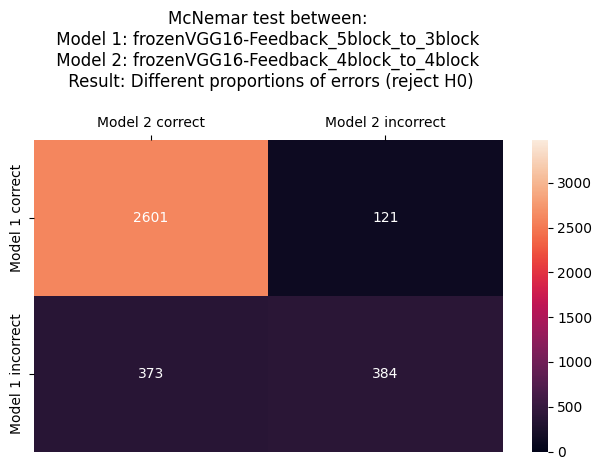

In [49]:
ds_len = len(test_ds_prepared_without_batch)
df = pd.DataFrame(result['contingency_table'],\
                  columns=['Model 2 correct', 'Model 2 incorrect'],\
                  index=['Model 1 correct', 'Model 1 incorrect'])
ax = sns.heatmap(df, annot=True, fmt=".0f", vmin=0, vmax=ds_len)
ax.set(xlabel="", ylabel="", title=f"McNemar test between:\n Model 1: {model_1_name} \n Model 2: {model_2_name} \n Result: {result['evaluation_result']}\n")
ax.xaxis.tick_top()
ax.figure.set_tight_layout(True)
plt.savefig('test mc nemar visualisation.png')

/scratch/slurm_tmpdir/job_21722285/ipykernel_662043/2862412127.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  glue = sns.load_dataset("glue").pivot("Model", "Task", "Score")


<AxesSubplot: xlabel='Task', ylabel='Model'>

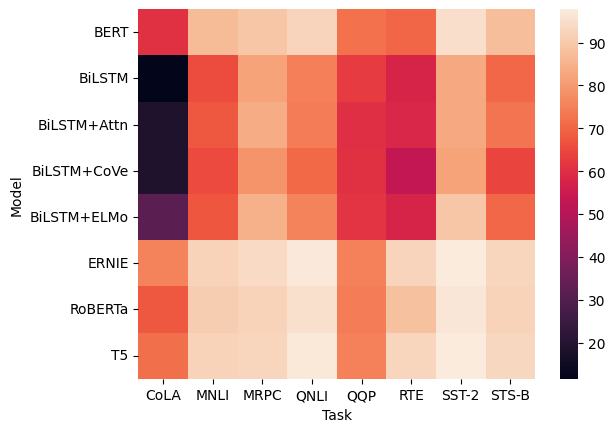

In [50]:
glue = sns.load_dataset("glue").pivot("Model", "Task", "Score")
sns.heatmap(glue)

In [51]:
glue

Task,CoLA,MNLI,MRPC,QNLI,QQP,RTE,SST-2,STS-B
Model,,,,,,,,
BERT,60.5,86.7,89.3,92.7,72.1,70.1,94.9,87.6
BiLSTM,11.6,65.6,81.8,74.6,62.5,57.4,82.8,70.3
BiLSTM+Attn,18.6,67.6,83.9,74.3,60.1,58.4,83.0,72.8
BiLSTM+CoVe,18.5,65.4,78.7,70.8,60.6,52.7,81.9,64.4
BiLSTM+ELMo,32.1,67.2,84.7,75.5,61.1,57.4,89.3,70.3
ERNIE,75.5,92.3,93.9,97.3,75.2,92.6,97.8,93.0
RoBERTa,67.8,90.8,92.3,95.4,74.3,88.2,96.7,92.2
T5,71.6,92.2,92.8,96.9,75.1,92.8,97.5,93.1
